# Linear Regression in Practice

In this notebook we use a linear model to describe a real-world dataset and implement least mean squares (LMS) to learn the optimal parameters. These notes focus on the practical application of linear models. They are the second of a two-part series, whose first part was devoted to the theoretical background.

For the data we will use a car prices dataset that can be downloaded from [kaggle page](https://www.kaggle.com/datasets/goyalshalini93/car-data). From that link we get a `csv` file, containing the actual data, and a `xlsx` file with a short description of the content. For the algorithm, instead of building functions and methods from scratch, we will use **Pytorch**, one of the most successful libraries in python for machine learning. 

For other implementations of a regression model on the same dataset, check out [this notebook](https://www.kaggle.com/code/goyalshalini93/car-price-prediction-linear-regression-rfe) and [this blog post](https://towardsdatascience.com/polynomial-regression-using-pytorch-from-scratch-500b7887b0ed).

As always, we begin by importing the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict

# custom functions from local file
from car_price_app.utils import plot_dataset, plot_history, plot_with_predicted

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


## Data loading

We now load the dataset from the `csv` file and store it as a pandas dataframe

In [2]:
car_prices_df = pd.read_csv('./car-data/CarPrice_Assignment.csv')
car_prices_df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


As it can be seen from above, the dataset contains $N \equiv 205$ examples, with $26$ columns each. We will not work with all this information for our simple regression problem. Instead, we keep only numerical data, which reduces the number of columns to $16$. From them, `car_ID` and `symboling` do not provide any useful information so we remove them as well.

In [3]:
regression_df = car_prices_df.select_dtypes([int, float]).drop(columns=['car_ID', 'symboling'])
regression_df.head(5)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


## Data splitting

Our regression problem consists on predicting car prices from car's characteristics, therefore, we need to split the dataset into features and targets. For the latter, we pick the obvious choice of $\pmb{y} \in \mathbb{R}^{N}$ to correspond to the price column. For convenience, we also convert the pandas series object into a numpy array and unsqueeze the vector.

In [4]:
Y = regression_df['price']
Y_a = np.expand_dims(Y.to_numpy(), 1)
print(Y.head())

0    13495.0
1    16500.0
2    16500.0
3    13950.0
4    17450.0
Name: price, dtype: float64


For the features, in principle we could just work directly with the remaining $13$ columns. However, we can lower this number by restricting only to those columns with a high correlation with the dependent variable.

In [5]:
threshold = 0.6
correlations = regression_df.corr()['price']
correlations.sort_values(ascending=False)

price               1.000000
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

We decide to keep only $D = 7$ features, corresponding to those columns reaching an absolute correlation value with the price column greater than $0.6$. Then, we pack the features into a design matrix $\pmb{X} \in \mathbb{R}^{N \times D}$, which we also convert to numpy array.

In [6]:
corr_mask = np.abs(correlations) >= threshold
X = regression_df.loc[:, corr_mask].drop(columns='price')
X_a = X.to_numpy()
X.head()

,carlength,carwidth,curbweight,enginesize,horsepower,citympg,highwaympg
0,168.8,64.1,2548,130,111,21,27
1,168.8,64.1,2548,130,111,21,27
2,171.2,65.5,2823,152,154,19,26
3,176.6,66.2,2337,109,102,24,30
4,176.6,66.4,2824,136,115,18,22


If needed, from the `xlsx` file we can read the description of each of these columns. The last two columns, for instance, correspond to the car's mileage in city (citympg) and in highway (highwaympg).

Now we perform a random split of the data into trainning and test sets. The former will be used for training the model, and the latter for validation. To this end we use a built-in function from scikit-learn called `train_test_split`, that takes the fraction of elements that goes to each set. We use a `seed` for reproducibility. 

In [7]:
train_frac = 0.7
seed = 100
X_train, X_test, Y_train, Y_test = train_test_split(X_a, Y_a, train_size=0.7, shuffle=True, random_state=seed)
print(len(Y_train), len(Y_test))

143 62


## Feature selection

In order to propose a reasonable linear model for the problem, it is worth performing a small graphical exploratory analysis of the data. For this case, it is sufficient to plot $\pmb{y}$ vs each feature separately to infer the functional dependence. 

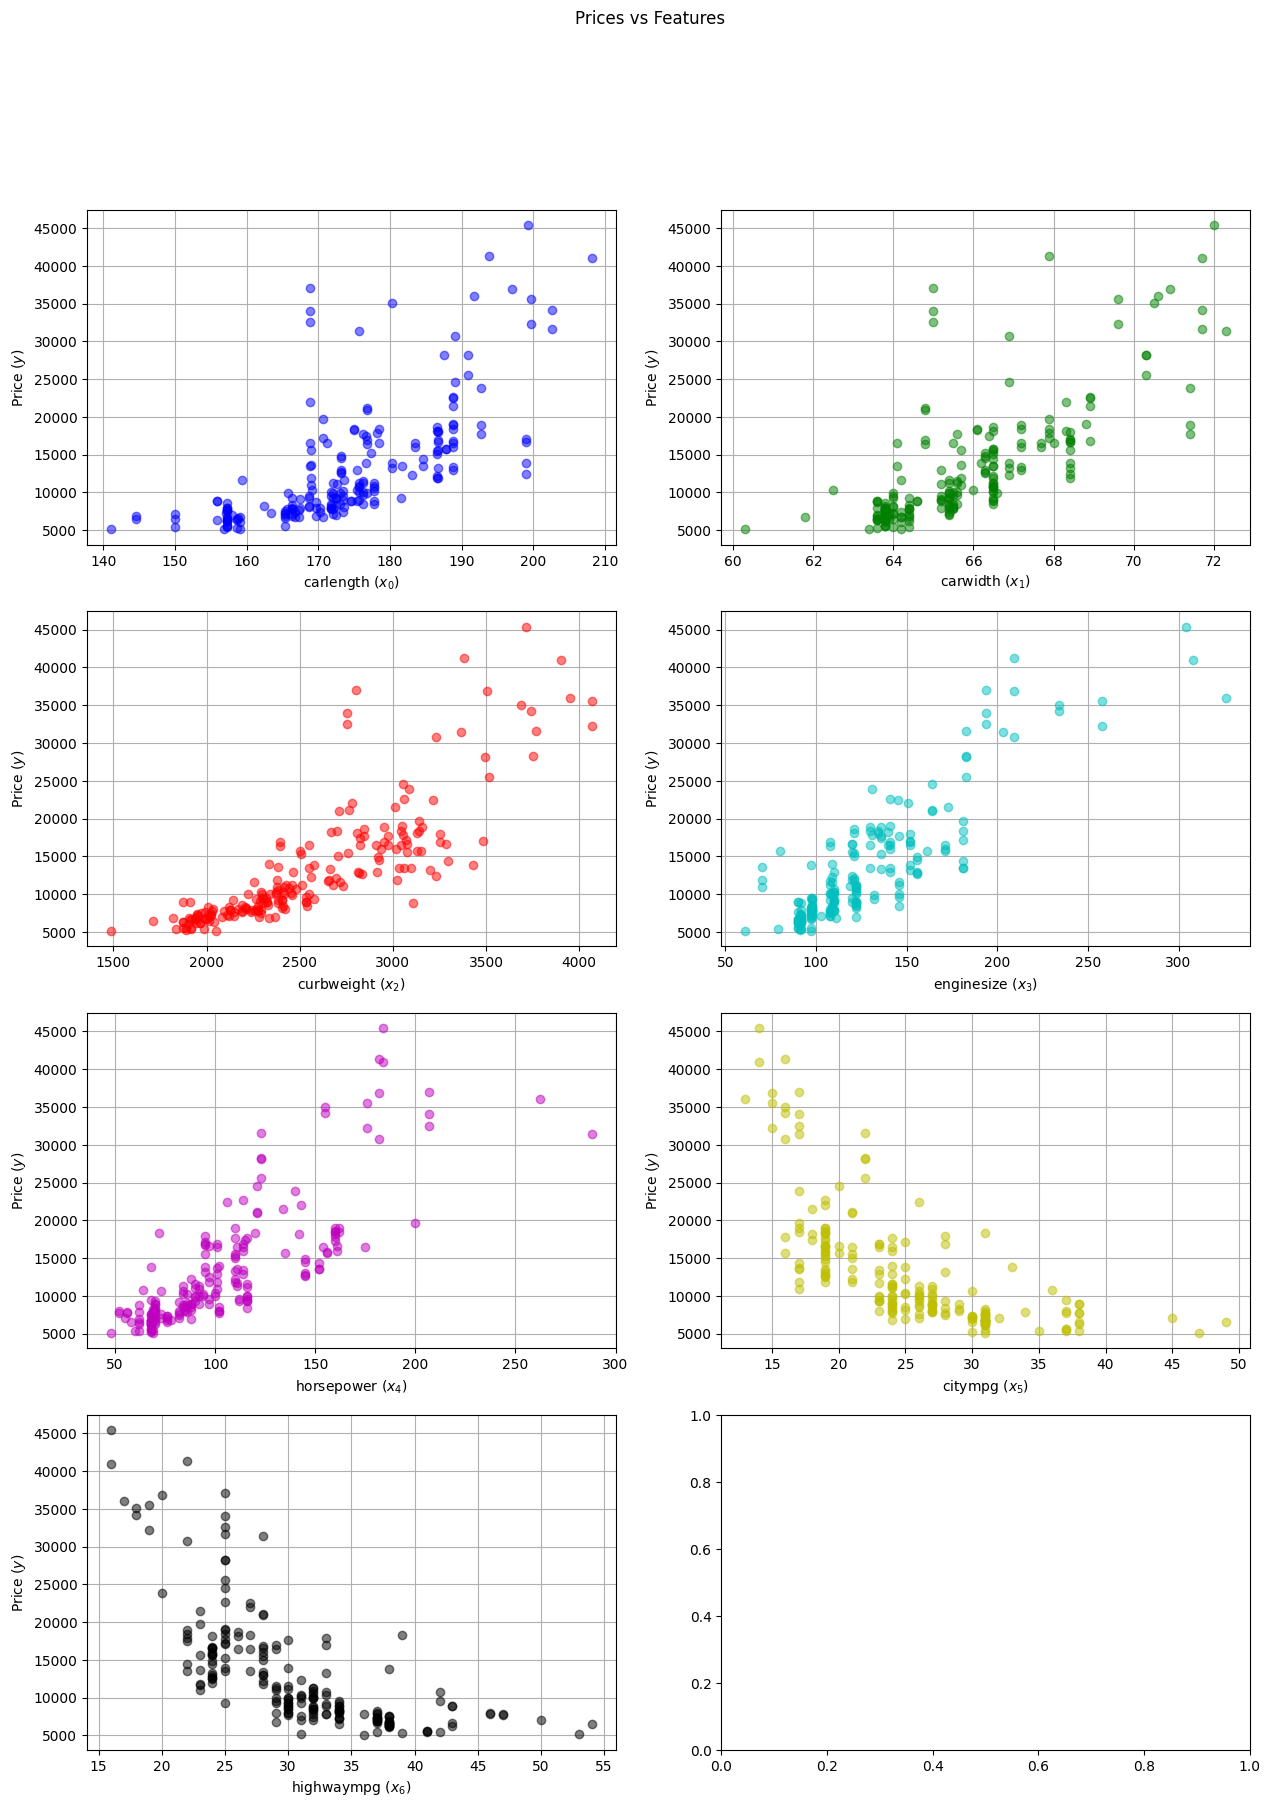

In [8]:
plot_dataset(X_a, Y_a, X.columns)

From the plots we can confirm what we saw from the correlation analysis: the first five features are positively correlated with the price while the two last are negatively correlated. Moreover, we can also infer the functional dependence, which for the positively correlated set seems to be 
$$y^{(i)} = \sum_{j=0}^{4}\left( \Theta_{1, j} x^{(i)}_{j} + \Theta_{2, j} x^{(i) 2}_{j}\right)$$
while for the remaining two features we propose
$$y^{(i)} = \sum_{j=5}^{6}\left( \Theta_{3, j}\frac{1}{x^{(i)}_{j}} + \Theta_{4, j}\frac{1}{x^{(i) 2}_{j}} \right)$$

This can be written in a more compact form by using $M$-dimensional basis functions of the form
$$ \pmb{\phi}(\pmb{x}) = (1, x_0, \dots, x_4, x_0^2, \dots, x_4^2, 1/x_5, 1/x_6, 1/x_5^2, 1/x_6^2)^T \in \mathbb{R}^{M + 1}$$
where we also included the intercept term. 

We implement this feature map by the following function:

In [9]:
def feature_map(x):
    # split into positive- and negative-correlated inputs
    x_pos = x[:, :5]
    x_neg = x[:, 5:]
    # define basis by applying the above mentioned non-linear functions
    phi = np.concatenate([x_pos, x_pos**2, 1/x_neg, 1/x_neg**2], axis=1)
    return phi

In [10]:
Phi_train = feature_map(X_train)
Phi_test = feature_map(X_test)
M = Phi_train.shape[1] + 1  # number of features plus intercept term
Phi_train.shape

(143, 14)

## Data normalization

Our dataset is currently enconded in arrays, built directly from the original car prices dataset. Now it's time to perform a small pre-processing step that usually improves the performance of the learning step. As they are now, the $14$ vector features (in both, training and test sets) have very diverse values. This can be corroborated by analyzing their mean and variance, which vary several orders of magnitude between features! Me take the train features as an example, but the same conclusions apply to the test set (indeed, they were just taken randomly from the same dataset).

In [11]:
print(f'mean: {np.mean(Phi_train, axis=0)}\nvariance: {np.var(Phi_train, axis=0)}')

mean: [1.73416783e+02 6.58398601e+01 2.53951049e+03 1.24958042e+02
 1.02552448e+02 3.02309835e+04 4.33975559e+03 6.74368330e+06
 1.72816434e+04 1.20838671e+04 4.21306020e-02 3.40631179e-02
 1.89639360e-03 1.22074648e-03]
variance: [1.57602795e+02 4.86841117e+00 2.94569774e+05 1.66713111e+03
 1.56686263e+03 1.92768338e+07 8.68445418e+04 8.95579677e+12
 1.81637709e+08 1.22038485e+08 1.21405979e-04 6.04504775e-05
 1.01377475e-06 3.30886645e-07]


This difference between features, and in particular the presence of high values for some of them, can harm the performance of our optimization step. In order to fix this one usually **normalizes** the inputs. There are several ways of doing so, here we use one of the simplest approaches called **min-max scaling**. This normalization is a simple linear transformation of the form 
$$ \pmb{x}_{\text{norm}} = \frac{\pmb{x} - \text{Min}(\pmb{x})}{\text{Max}(\pmb{x}) - \text{Min}(\pmb{x})}$$
 
We need to apply this transformation on the vector features of both training and test sets. However, and this is crucially important, the parameters of the transformation must be fit using the training data only. This is because during the training process there can be no information (leak) coming from the test set that could bias our conclusions. Additionally, in some real-life situations we don't even have access to the test set beforehand. Therefore, the parameters in min-max scaling, namely $\text{Min}(\pmb{x})$ and $\text{Max}(\pmb{x})$ are the min and max values over the $N_{\text{train}}$-dimensional vector features of the training set. With these same parameters we then need to transform the test features as well, so the trained model is then equally applicable to the test set. (For more information on normalization and other scaling techniques, check out [this nice post](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)!)

On the training set, the net effect of min-max scaling is to convert the data such that all values lie between $0$ and $1$. Obviously this may not be the case for the test set, since the minimum and maximum values therein may be different from the ones used in the transformation. However, if we believe that both sets are representative realizations of the random sample, these min and max values shouldn't be so far from $0$ and $1$ respectively. 

We can easily implement min-max scaling ourselves. We do that through a `transformation` class that also includes other common preprocessing steps: it converts the normalized data into tensor objects, the standard data type to work in Pytorch, and appends an intercept term.

In [12]:
class transformation:
    def __init__(self, min_, max_):
        self.min = min_
        self.max = max_
    def feature_transform(self, x):
        # normalize features
        x_new = (x - self.min)/(self.max - self.min)
        # convert features into tensors
        x_new = torch.tensor(x_new, dtype=torch.float32)
        # add intercept term
        x_new = torch.cat((torch.ones(x_new.shape[0], 1), x_new), dim=1)
        return x_new

    def target_transform(self, y):
        return torch.tensor(y, dtype=torch.float32)

In [13]:
# initialize transformation 
train_min = Phi_train.min(axis=0)
train_max = Phi_train.max(axis=0)
normalization = transformation(train_min, train_max)
# apply it over dataset
Phi_train_norm = normalization.feature_transform(Phi_train)
Phi_test_norm = normalization.feature_transform(Phi_test)
Y_train_norm = normalization.target_transform(Y_train)
Y_test_norm = normalization.target_transform(Y_test)

After this transformation we can check that, indeed, the training features were correctly normalized

In [14]:
print(f'mean: {torch.mean(Phi_train_norm, dim=0)}\nvariance: {torch.var(Phi_train_norm, dim=0)}')
print(f'min: {torch.min(Phi_train_norm, dim=0)[0]}\nmax: {torch.max(Phi_train_norm, dim=0)[0]}')

mean: tensor([1.0000, 0.5255, 0.4617, 0.4079, 0.2414, 0.2273, 0.4883, 0.4422, 0.3163,
        0.1322, 0.1213, 0.3844, 0.3857, 0.2690, 0.2816])
variance: tensor([0.0000, 0.0420, 0.0340, 0.0446, 0.0239, 0.0274, 0.0434, 0.0345, 0.0440,
        0.0174, 0.0189, 0.0383, 0.0375, 0.0337, 0.0343])
min: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
max: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


and the same for the test set

In [15]:
print(f'mean: {torch.mean(Phi_test_norm, dim=0)}\nvariance: {torch.var(Phi_test_norm, dim=0)}')
print(f'min: {torch.min(Phi_test_norm, dim=0)[0]}\nmax: {torch.max(Phi_test_norm, dim=0)[0]}')

mean: tensor([1.0000, 0.5595, 0.4804, 0.4285, 0.2657, 0.2489, 0.5217, 0.4602, 0.3295,
        0.1499, 0.1341, 0.3965, 0.3960, 0.2783, 0.2920])
variance: tensor([0.0000, 0.0361, 0.0274, 0.0322, 0.0265, 0.0267, 0.0380, 0.0281, 0.0312,
        0.0241, 0.0149, 0.0363, 0.0402, 0.0330, 0.0426])
min: tensor([1.0000, 0.0569, 0.1833, 0.1284, 0.0679, 0.0167, 0.0473, 0.1698, 0.0764,
        0.0246, 0.0050, 0.1045, 0.0684, 0.0502, 0.0352])
max: tensor([1.0000, 1.0894, 0.9750, 0.9356, 0.9321, 0.6625, 1.1069, 0.9728, 0.9076,
        0.8887, 0.5028, 0.9028, 1.0912, 0.8518, 1.1431])


As we anticipated, while for the training set all features lie between $[0, 1]$, this is not the case for the test set. However, the difference is relatively small.

## Dataset and Dataloder

Now that we have our data as normalized tensor objects, its time to express it as an element of Pytorch Dataset class that later will be fed into a Pytorch Dataloader. The former stores all your data, and the latter can be used to iterate through it, manage batches, transform the data, and much more. This two-step procedure keeps your data manageable and helps to simplify your machine learning pipeline.

The standard way of using customize dataset in Pytorch is to create a subclass of Pytorch Dataset class. This subclass needs at least two methods, ``__len__`` and ``__getitem__``. The former gives the length of the dataset and the latter allows us to slice over its elements. In principle we can create a dataset using directly the pre-processed data. However, its a good and common practice to incorporate this step inside Dataset class methods. This is achieved by adding an additional `transform` parameter.

In [16]:
class CarPricesDataset(Dataset):
    def __init__(self, features, target, transform=None):
        self.features = features
        self.target = target
        self.transform = transform
    def __len__(self):
            return len(self.target)
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.target[idx]

        # catch cases with no slice index
        if type(idx) == int:
            x = x.reshape(1, -1)
            y = y.reshape(1, -1)

        # transform input
        if self.transform:
            x = self.transform.feature_transform(x)
            y = self.transform.target_transform(y)

        return x, y

In [17]:
# initialize training and test sets from unormalized data
trainset = CarPricesDataset(Phi_train, Y_train, transform=normalization)
testset = CarPricesDataset(Phi_test, Y_test, transform=normalization)

Finally, we create a DataLoader for the training set

In [18]:
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
x_batch, y_batch = next(iter(train_loader))
print(len(x_batch), x_batch.shape, len(y_batch), y_batch.shape)

16 torch.Size([16, 1, 15]) 16 torch.Size([16, 1, 1])


## Model, loss and optimizer

It was a long journey but finally we have the dataset ready to be trained! However, before starting with the training loop, we need three extra ingredients: a model, a loss function and and optimizer.

As anticipated, we use a linear model of the form
$$h_{\pmb{\Theta}}(\pmb{x}) = \sum_{k=0}^{M-1} \Theta_{k} \phi_{k}(\pmb{x}) = \pmb{\Theta} \pmb{\phi}(\pmb{x})$$
where $\Theta_{k}$ are the parameters we need to train and in our case we have $M=15$ of them. With Pytorch this model is easily implemented by using the ``nn.Linear`` method.

In [19]:
# model
model = nn.Linear(M, 1, bias=False)

It is interesting to note that by initializing the model in that way, behind the scenes Pytorch already took care of defining the weights which will be trained in later. These can be seen by checking the model's parameters attribute 

In [20]:
init_parameters = next(model.parameters())
print(init_parameters, len(init_parameters[0]))

Parameter containing:
tensor([[ 0.0129, -0.1597,  0.0171,  0.0905,  0.1111, -0.1125,  0.0434,  0.1059,
         -0.0638,  0.2280,  0.2066, -0.2096, -0.1238, -0.0349,  0.0472]],
       requires_grad=True) 15


which contains the curious `requires_grad` attribute. This property states that, from now on, Pytorch will remember any function applied over the parameters so to keep track of partial derivatives. This will be extremelly useful later for optimization, in which we need the gradient of the loss function. 

Now, we define the loss function to be the Mean Squared Error (MSE) function 
$$ J(\pmb{\Theta}) = \frac12 ||\pmb{\Phi} \pmb{\Theta} - \pmb{Y}||_2^2\,, $$
by using `nn.MSELoss`

In [21]:
# loss function
loss_func = nn.MSELoss()

Finally, for the optimizer we choose mini-batch Stochastic Gradient Descent (SGD) which applies the update rule
$$\pmb{\Theta}:= \pmb{\Theta} - \alpha \sum_{i=1}^{B} \left[\pmb{\Theta}^T \pmb{\phi}(\pmb{x}^{(i)}) - y^{(i)} \right] \pmb{\phi}(\pmb{x}^{(i)})\,,$$
for an already-defined $B =$ `batch_size` and a learning rate $\alpha$.

In [22]:
# optimizer
alpha = 1e-2  # learning rate
optimizer = optim.SGD(model.parameters(), lr=alpha)

## Training the model

Finally, we define a function that given a dataset, model, loss function and optimizer will implement the training process. This function will also store some intermediate values so to keep track of the model's performance during training.

In [23]:
def train_model(epochs, dataloader, model, loss_func, optimizer, testset, display_freq=100):
    
    # use for evaluating the model during training
    x_test, y_test = testset[:]
    
    # store training history into dictionary
    history_dic = {'train': torch.zeros(epochs),
                   'test': torch.zeros(epochs),
                   'weights': torch.zeros([epochs, 1, M])}

    # training loop
    for epoch in range(epochs): 
        model.train()  # activates training mode
        
        for x, y in dataloader:
            
            optimizer.zero_grad() # restarts gradient for each batch so not to accumulate
            y_pred = model(x) # predicted value
            loss_train = loss_func(y_pred, y)
            loss_train.backward() # computes gradient
            optimizer.step() # updates parameters

        # evaluate trained model on test data
        model.eval()  # activates evaluation mode
        y_test_pred = model(x_test)
        loss_test = loss_func(y_test_pred, y_test)
        
        # store loss for train and test data and parameters
        history_dic['train'][epoch] = loss_train.item()
        history_dic['test'][epoch] = loss_test.item()
        history_dic['weights'][epoch] = next(model.parameters()).data
        
        # display partial loss every display_freq epochs
        if epoch%display_freq==0:
            print(f'epoch {epoch}: Training loss {loss_train.item()}, Test loss {loss_test.item()}')
    
    # best epoch choosen from minimum of test error
    best_epoch = torch.argmin(history_dic['test'])
    optimal_weights = history_dic['weights'][best_epoch]
    
    print(f'\nBest epoch = {best_epoch}')
    print(f'Training loss = {history_dic["train"][best_epoch]}')
    print(f'Lowest Test loss = {history_dic["test"][best_epoch]}')
    
    return history_dic, optimal_weights

Now we have everything to train our model, so we pick specific values for the hyperparameters, namely learning rate, number of epochs, etc. and run the algorithm.

In [24]:
# parameters
alpha = 1e-2  # learning rate
epochs = 3000

# model
model = nn.Linear(M, 1, bias=False)

# loss function
loss_func = nn.MSELoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=alpha)

history_dic, optimal_weights = train_model(epochs, 
                                           train_loader, 
                                           model, 
                                           loss_func, 
                                           optimizer, 
                                           testset, 
                                           display_freq=100)

epoch 0: Training loss 47639620.0, Test loss 108183616.0
epoch 100: Training loss 3035371.5, Test loss 16299423.0
epoch 200: Training loss 17207272.0, Test loss 15027457.0
epoch 300: Training loss 26123404.0, Test loss 14444775.0
epoch 400: Training loss 6963073.5, Test loss 14115395.0
epoch 500: Training loss 7094873.5, Test loss 13902120.0
epoch 600: Training loss 5829873.0, Test loss 13752046.0
epoch 700: Training loss 7425778.5, Test loss 13653600.0
epoch 800: Training loss 20105770.0, Test loss 13576549.0
epoch 900: Training loss 4399864.5, Test loss 13542216.0
epoch 1000: Training loss 14874014.0, Test loss 13510743.0
epoch 1100: Training loss 24106334.0, Test loss 13482398.0
epoch 1200: Training loss 23543320.0, Test loss 13460206.0
epoch 1300: Training loss 18811892.0, Test loss 13445647.0
epoch 1400: Training loss 23167916.0, Test loss 13446786.0
epoch 1500: Training loss 9772205.0, Test loss 13447174.0
epoch 1600: Training loss 3702319.75, Test loss 13416840.0
epoch 1700: Tra

## History plots

During the training process we stored the parameters, and training and evaluation loss for each epoch so keep track of how the training loop evolved. Now, we plot these quantities

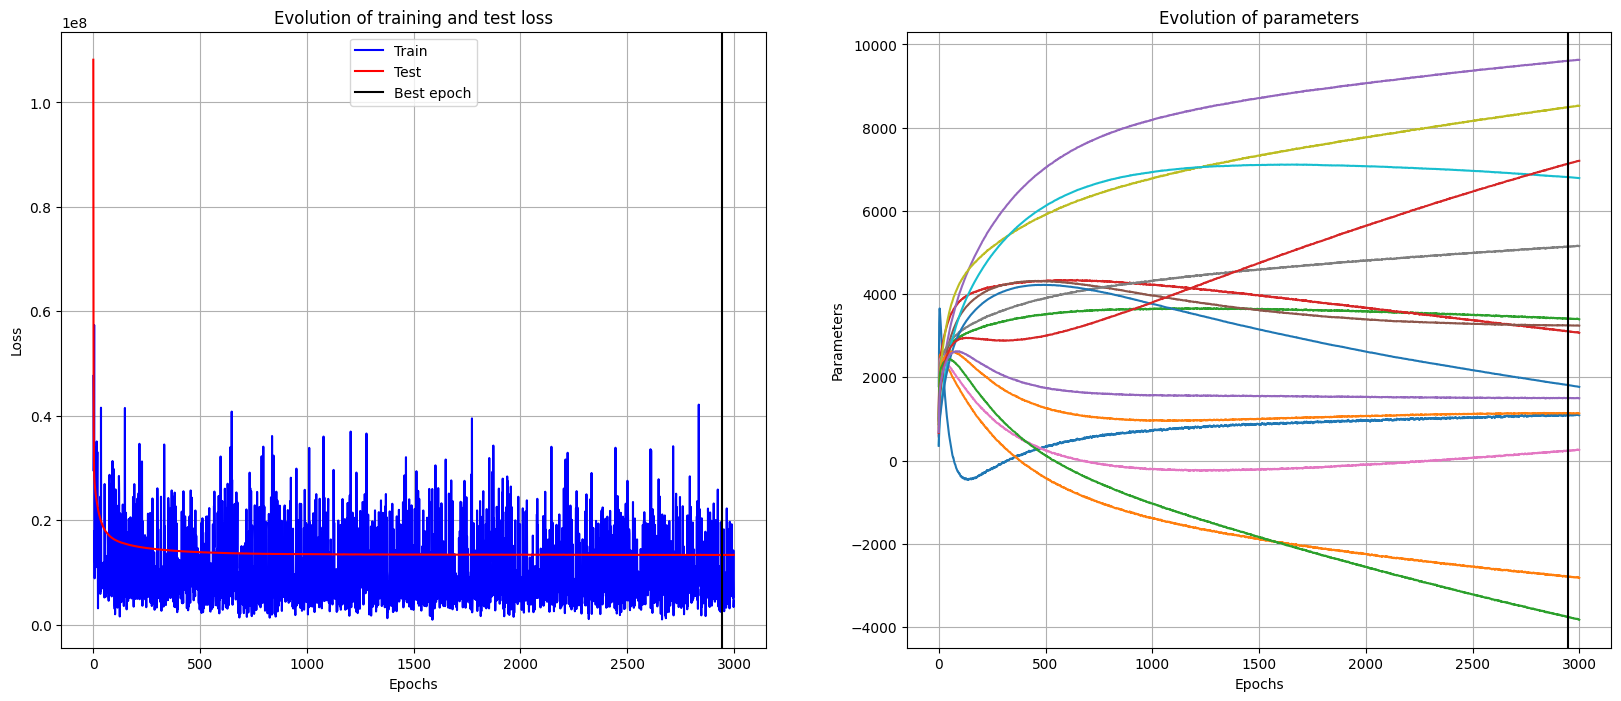

In [25]:
plot_history(history_dic)

## Saving the model

It would be a bit annoying to have to train the model everytime we open the file or everytime we want to do just inference. Luckily, we do not have to go over that, we can simply save the model's essential parameters so to load them later. For this particular example, we will need the model's weights and the parameters of the transformation, namely `min_` and `max_` in the `transformation` class above.

For the model's weights, we need to save the model's state which is stored in the `state_dic` attribute

In [26]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ 1090.4835, -2819.2236,  3394.9480,  3069.1941,  9628.6465,  3241.9797,
                         253.3821,  5153.0156,  8524.2324,  6786.6670,  1769.7423,  1132.4113,
                       -3825.3079,  7203.0010,  1496.6987]]))])

However, the model now contains the parameters corresponding to the last training epoch, and we know they are not the optimal ones. The latter were stored in the training process and so we store those values instead

In [27]:
best_state = OrderedDict({'weight': optimal_weights})
best_state

OrderedDict([('weight',
              tensor([[ 1104.0005, -2778.0244,  3419.6746,  3114.6753,  9610.1455,  3253.0930,
                         244.0303,  5148.0439,  8496.1445,  6814.8247,  1818.8478,  1144.5959,
                       -3749.2461,  7135.1650,  1507.1410]]))])

For the transformation parameters we simply store them in a different dictionary

In [28]:
min_max ={'min': normalization.min, 'max': normalization.max}

Finally, we save these two set of parameters into a local file

In [29]:
model_path = './model_e3000.pth'
torch.save({'state': best_state, 'transformation_parameters': min_max}, model_path)

We can now check that they were saved properly by initializing the model again, corroborating it begins with random parameters, and loading the best state

In [30]:
model = nn.Linear(M, 1, bias=False)
print(model.state_dict())

state = torch.load(model_path)['state']
min_max = torch.load(model_path)['transformation_parameters']

model.load_state_dict(state)
print(model.state_dict())

OrderedDict([('weight', tensor([[-0.0371,  0.0163,  0.0705,  0.2148, -0.2333, -0.1870,  0.2498, -0.1900,
         -0.1092,  0.1864,  0.0525, -0.1452, -0.1993,  0.0395, -0.0598]]))])
OrderedDict([('weight', tensor([[ 1104.0005, -2778.0244,  3419.6746,  3114.6753,  9610.1455,  3253.0930,
           244.0303,  5148.0439,  8496.1445,  6814.8247,  1818.8478,  1144.5959,
         -3749.2461,  7135.1650,  1507.1410]]))])


These are indeed the optimal weights we saved before!

## Evaluate the model on test set

At this point, we are in possession of a trained model that can predict the price of a car given the seven characteristics mentioned above. To this end, we create a function that takes this vector, transform it accordingly to fit it into the model and return the car's price

In [31]:
def predict_price(x, min_, max_):
    min_max_scaling  = transformation(min_, max_)
    phi = feature_map(x)
    phi_norm = min_max_scaling.feature_transform(phi)
    y_pred = model(phi_norm).data
    return y_pred

We can use this function to do inference on any car we are interested in! In particular, we can apply it to the test data to see how the model performs.

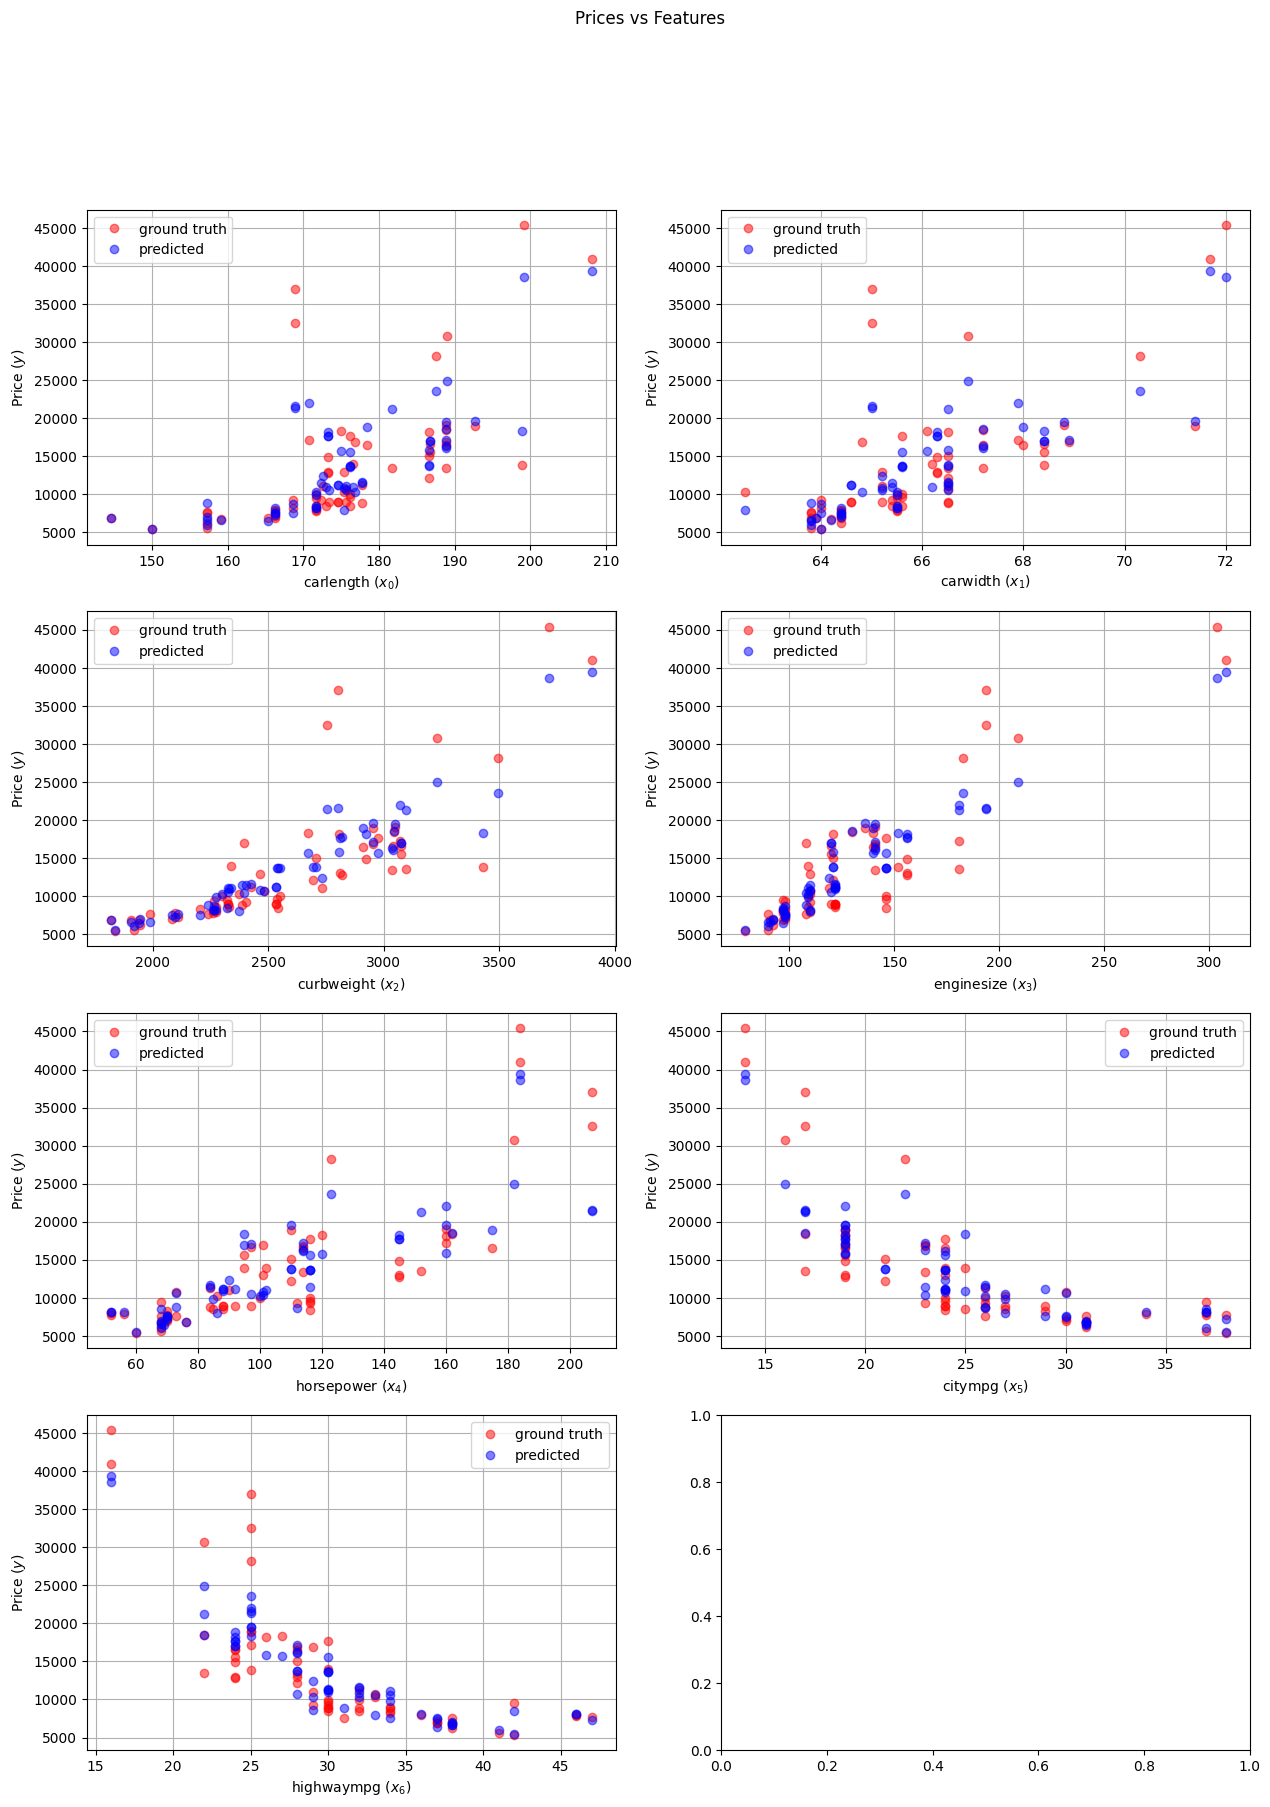

In [32]:
Y_test_pred = predict_price(X_test, min_max['min'], min_max['max'])
plot_with_predicted(X_test, Y_test, Y_test_pred, X.columns)

In order to have a more quantitative measure of performance we need a suitable **error metric**. An example of such a quantity is MSE, which we used during the training process. However, saying that the loss for the test set is $13351099.0$ does not tell us much... For this purpose, we can use another metric for linear regression, the **R-squared score**, which is a statistical measure that indicates how well the predictions approximate the real data points. This metric is easily implemented in practice via the formula:
$$R^2 = 1 - \frac{||\pmb{Y} - \hat{\pmb{Y}}||_2^2}{||\pmb{Y} - \bar{\pmb{Y}}||_2^2}$$
where $\hat{\pmb{Y}}$ is the prediced target, which in in our case is given by $\hat{\pmb{Y}} = \pmb{\Phi} \pmb{\Theta}$, and $\bar{\pmb{Y}}$ is the mean value. This function is already implemented in Pytorch, it is called `r2_score` from the module `torcheval.metrics.functional`, and so will use it.

In [33]:
R2_test = r2_score(torch.tensor(Y_test), Y_test_pred).item()
print(R2_test)

0.7093271877791908


This metric is much better for interpretation! That number implies that around $70\%$ of the variability of the dependent variable in the dataset is explained by our model. If we would compute this metric on the training set, we would definitely get a higher score, since the model was trained exactly on this data. Indeed:

In [34]:
Y_train_pred = predict_price(X_train, min_max['min'], min_max['max'])
R2_train = r2_score(torch.tensor(Y_train), Y_train_pred).item()
print(R2_train)

0.8100653906377477
